# **Airline Planning and Operations**
## **Assignment 1**

In this notebook, the data files needed to solve the questions in the assignment are imported and explained. At the end, an example of using Gurobi to solve a very simple network model is given.

***

## Set-up
The MILP problems of the assignment can be solved using Gurobi. An introduction to Gurobi can be found [here](https://www.gurobi.com/resource/mathematical-programming-tutorial-linear-programming/). To use Gurobi, you need to obtain the [Academic License](https://www.gurobi.com/features/academic-named-user-license/).

Now, we will import more Python packages that will be used in the model.

In [41]:
from gurobipy import *
import numpy as np
import pandas as pd
import math
import plotly.graph_objects as go

In the cell below you can fill in your group number in order to read the data files.

In [42]:
group = 1 # Fill in your group number here

---

## Introduction to the data
The code below reads the data files of your group. The airports in your network can be found on the map and the table below. Make sure that the folder containing the data files is located in the working directory of this notebook.


In [43]:
airport_data = pd.read_csv('Group_'+str(group)+'_Airport_info.csv',  encoding = 'unicode_escape',index_col=1)
demand_data = pd.read_csv('Group_'+str(group)+'_Demand.csv', encoding = 'unicode_escape',index_col=0)
distance_data = pd.read_csv('Group_'+str(group)+'_Distances.csv', encoding = 'unicode_escape',index_col=0)
aircraft_data = pd.read_csv('Aircraft_info.csv', encoding = 'unicode_escape')
annual_growth_csv = pd.read_csv('Group_'+str(group)+'_Annual_growth.csv', encoding = 'unicode_escape', header=None)
annual_growth = annual_growth_csv[0][0]
airports = airport_data.index
hub = airports[0]
print('The hub of your network is', hub)

The hub of your network is LIMC


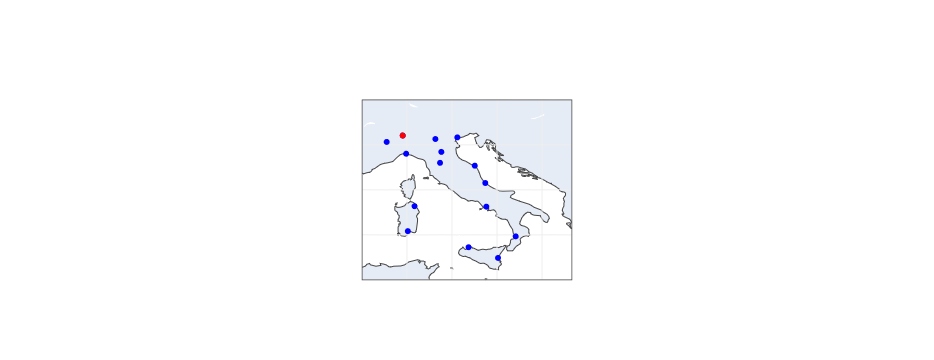

In [44]:
fig = go.Figure(data=go.Scattergeo())
fig.add_trace(go.Scattergeo(lat =(airport_data['Latitude (deg)']), lon= (airport_data['Longitude (deg)']), text =airports,  line = dict( color = "blue")))
fig.add_trace(go.Scattergeo(lat =([airport_data.loc[hub]['Latitude (deg)']]), lon= ([airport_data.loc[hub]['Longitude (deg)']]), text =airports, line = dict( color = "red")))
fig.update_layout(showlegend=False, geo=dict(resolution=50, lataxis=dict(range=[36, 48], showgrid=True, dtick=3), lonaxis=dict(range=[6, 20], showgrid=True, dtick=3)))
fig.show()

In [45]:
airport_data

,City Name,Latitude (deg),Longitude (deg),Runway (m),Population,GDP
ICAO Code,,,,,,
LIMC,Malpensa,45.626396,8.712519,3920,11117615,468.77
LICJ,Palermo,38.182400,13.100582,3326,1880634,89.36
LIMF,Torino,45.200499,7.643164,3300,477617,137.78
LIEE,Cagliari,39.251539,9.055672,2803,994409,35.25
LIRQ,Firenze,43.808653,11.201225,1750,5827084,118.72
LIPZ,Venezia,45.503200,12.351200,3300,5658163,164.86
LIEO,Olbia,40.916668,9.500000,2745,640734,35.25
LIMJ,Genova,44.414165,8.942184,3066,3422620,49.74
LIBP,Pescara,42.461788,14.216090,2419,2005440,33.13


If desired, you can check out the aircraft, demand and airport distance data by executing the following pieces of code.

In [46]:
aircraft_data

,AC_type,Speed,Seats,TAT,Charging,Range,Runway,Lease_c,Operating_c,Time_c,Fuel_c,Energy_c
0,Regional Turboprop,550,45,25,0,1500,1400,15000,300,750,1.00,0
1,Regional Jet,820,70,35,0,3300,1600,34000,600,775,2.00,0
2,Single Aisle Twin Engine Jet,850,150,45,0,6300,1800,80000,1250,1400,3.75,0
3,Electric twinprop aircraft,350,20,20,20,400,750,12000,90,750,0.00,2130
4,Electric regional aircraft,480,48,25,45,1000,950,22000,120,750,0.00,8216


The following table contains the demand from the year 2020.

In [47]:
demand_data

,LIRN,LICJ,LIPX,LIRQ,LIBP,LIPY,LIMF,LICC,LIMC,LIPZ
LIRN,0,66,117,104,90,93,46,97,162,105
LICJ,77,0,63,66,46,40,24,65,84,61
LIPX,103,56,0,141,63,79,68,70,244,160
LIRQ,120,67,125,0,65,104,46,80,180,136
LIBP,86,40,71,75,0,53,27,49,88,70
LIPY,79,43,74,83,58,0,28,50,103,84
LIMF,50,26,60,56,26,25,0,28,118,54
LICC,97,69,79,66,53,49,33,0,109,82
LIMC,165,95,211,204,105,115,124,97,0,235
LIPZ,125,75,168,148,74,87,60,87,207,0


The population of all regions is expected to grow with the following fixed annual growth factor.

In [48]:
print(str(annual_growth) + '%')

0.84%


In [49]:
distance_data

,LIMC,LICJ,LIMF,LIEE,LIRQ,LIPZ,LIEO,LIMJ,LIBP,LIPX,LICA,LICC,LIRN,LIPE,LIPY
LIMC,0.000000,903.524942,95.968228,709.408865,281.967972,283.569923,527.556560,135.997095,563.086457,171.481258,969.824069,1049.253474,693.856843,235.838017,440.900626
LICJ,903.524942,0.000000,901.883665,370.482131,645.547025,816.388380,433.213355,774.872620,485.138921,822.689364,284.923029,190.037301,317.179906,722.376532,605.302194
LIMF,95.968228,901.883665,0.000000,671.609317,321.780985,369.379652,499.619078,134.708939,608.586693,254.747674,995.903938,1058.924225,722.018414,296.629053,498.529850
LIEE,709.408865,370.482131,671.609317,0.000000,537.226865,745.823971,188.972469,574.134662,561.752840,699.563756,621.451034,560.188705,480.709883,615.860714,611.286418
LIRQ,281.967972,645.547025,321.780985,537.226865,0.000000,209.225285,350.616247,192.503832,286.810469,178.199367,688.338876,776.641265,412.369247,81.115581,187.309894
LIPZ,283.569923,816.388380,369.379652,745.823971,209.225285,0.000000,559.807987,294.268005,369.615047,114.724366,800.252092,921.564342,537.042219,136.212707,229.161277
LIEO,527.556560,433.213355,499.619078,188.972469,350.616247,559.807987,0.000000,391.566316,427.556431,510.598572,616.838156,613.925708,402.364706,428.063258,446.436549
LIMJ,135.997095,774.872620,134.708939,574.134662,192.503832,294.268005,391.566316,0.000000,477.835406,188.162430,861.256968,927.407435,587.321416,186.660820,376.334373
LIBP,563.086457,485.138921,608.586693,561.752840,286.810469,369.615047,427.556431,477.835406,0.000000,421.158992,430.660933,560.053904,175.543070,329.990839,140.461363
LIPX,171.481258,822.689364,254.747674,699.563756,178.199367,114.724366,510.598572,188.162430,421.158992,0.000000,845.418184,947.536310,572.362657,100.703504,287.298800


***

## Example Gurobi network model

Below is an example network model solved using Gurobi. The first cell contains the data of the network, which contains three airports. The goal is to find the frequencies to fly between the destinations for which the airline makes the largest profit.

__Sets__
* N: the set of airports

__Parameters__
* $q_{ij}$: traffic demand between airport i to airport j
* $d_{ij}$: distance between airports i and j
* Yield: revenue per RPK flown (average yield)
* s: number of seats per aircraft
* CASK: unit operation cost per ASK flown
* sp: speed of the aircraft
* LF: average load factor
* AC: number of aircraft
* LTO: extra landing and take-off time
* BT: aircraft avg. utilisation time

In [50]:
# Data
Airports = ['A1','A2','A3']
N = range(len(Airports))
CASK = 0.12
LF = 0.75
s = 120
sp = 870
LTO = 20/60
BT = 10
AC = 2
y = 0.18  # yield
q = [[0, 1000, 200],
          [1000, 0, 300],
          [200, 300, 0]]
distance = [[0, 2236, 3201],
          [2236, 0, 3500],
          [3201, 3500, 0]]

In the following cell the variables, objective function and constraints of the problem are defined.

__Decision variables__
* $z_{ij}$ : number of flights from airport i to airport j
* $x_{ij}$ : flow from airport i to airport j

__Objective function__
* max profit $ = \sum_{i \in N} \sum_{j \in N} (Yield * d_{ij} * x_{ij} - CASK * d_{ij} * s * z_{ij})$

__Constraints__
* $x_{ij} \leq q_{ij} \quad \forall i,j \in N$
* $x_{ij} \leq z_{ij} * s * LF \quad \forall i,j \in N$
* $\sum_{j \in N} z_{ij} = \sum_{j \in N} z_{ji} \quad \forall i \in N$
* $\sum_{i \in N} \sum_{j \in N} (\frac{d_{ij}}{sp} + LTO) * z_{ij} \leq BT * AC$

In [51]:
# Start modelling optimization problem
m = Model('practice')

# Variables
x = {}
z = {}
for i in N:
    for j in N:
        x[i,j] = m.addVar(obj = y*distance[i][j],lb=0,
                           vtype=GRB.INTEGER)
        z[i,j] = m.addVar(obj = -CASK*distance[i][j]*s, lb=0,
                           vtype=GRB.INTEGER)
        
# if you prefer to separate the definition of decision variables and objective function you can do so as follows. 
    # A = [(i, j) for j in N for i in N]
    # VARIABLES
        # x = m.addVars(A, vtype=GRB.INTEGER, lb=0)
        # z = m.addVars(A, vtype=GRB.INTEGER, lb=0)
    # OBJECTIVE FUNCTION
        # obj = quicksum(y*distance[i][j]*x[i,j] for i, j in A) - quicksum(CASK*distance[i][j]*s*z[i,j] for i, j in A)
        # m.setObjective(obj)
    
m.update()
m.setObjective(m.getObjective(), GRB.MAXIMIZE)  # The objective is to maximize revenue

# Constraints
# there are multiple ways to implement and name constraints:
    # E.g. 1) Add constraint: x + y >= 1
        # m.addConstr(x + y >= 1, "NameOfConstraints_%i_%s" %(j, "string"))
    # E.g. 2)
        # m.addConstr(lhs= , GRB.EQUAL, rhs= , name="NameOfConstraints_%i_%s" %(j, "string"))
    # E.g. 3) If you know that the constraint is linear you can declare it with the following
    # nomenclature to reduce the calculation time up to 50%:
        # m.addLConstr()
for i in N:
    for j in N:
        m.addConstr(x[i,j], GRB.LESS_EQUAL, q[i][j]) #C1
        m.addConstr(x[i,j], GRB.LESS_EQUAL, z[i,j]*s*LF) #C2
    m.addConstr(quicksum(z[i,j] for j in N), GRB.EQUAL, quicksum(z[j, i] for j in N)) #C3

m.addConstr(quicksum(quicksum((distance[i][j]/sp+LTO)*z[i,j] for i in N) for j in N),
            GRB.LESS_EQUAL, BT*AC) #C4

<gurobi.Constr *Awaiting Model Update*>

Then, the problem can be optimized. For larger models it is possible to set a time constraint.

In [52]:
m.update()
# m.write('test.lp')
# Set time constraint for optimization (5minutes)
# m.setParam('TimeLimit', 5 * 60)
# Set gap constraint for optimisation
# m.setParam('MIPgap', 0.0003)

m.optimize()
# m.write("testout.sol")
status = m.status

if status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is unbounded')

elif status == GRB.Status.OPTIMAL or True:
    f_objective = m.objVal
    print('***** RESULTS ******')
    print('\nObjective Function Value: \t %g' % f_objective)

elif status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
    print('Optimization was stopped with status %d' % status)

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 22 rows, 18 columns and 48 nonzeros
Model fingerprint: 0x037a8259
Variable types: 0 continuous, 18 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 9e+01]
  Objective range  [4e+02, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 16 rows and 10 columns
Presolve time: 0.00s
Presolved: 6 rows, 8 columns, 20 nonzeros
Variable types: 0 continuous, 8 integer (0 binary)
Found heuristic solution: objective 16099.200000

Root relaxation: objective 2.892348e+04, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 28923.4828    0    3 16099.2000 28923.4828  79.7%     -    0s
H    

Run the following code to print out the solutions.

In [39]:
# Print out solutions
print()
print("Frequencies:----------------------------------")
print()
for i in N:
    for j in N:
        if z[i,j].X >0:
            print(Airports[i], ' to ', Airports[j], z[i,j].X)


Frequencies:----------------------------------

A1  to  A2 1.0
A2  to  A3 2.0
A3  to  A1 1.0
A3  to  A2 1.0
